In [1]:
#imports
import cv2
import numpy as np
import sys

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage.color import rgb2gray
from skimage.filters import median,threshold_otsu
from skimage.morphology import binary_closing,binary_opening 
from skimage.feature import canny
from skimage.measure import find_contours
from sklearn.cluster import KMeans

In [2]:
#detect shape of contours
def detect(c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        (x, y, w, h) = cv2.boundingRect(approx)
        ar = w / float(h)
        # if the shape is a triangle, it will have 3 vertices
        if len(approx) == 3:
            shape = "triangle"
        # if the shape has 4 vertices, it is either a square or
        # a rectangle
         
        elif len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
          
            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
        # if the shape is a pentagon, it will have 5 vertices
        elif len(approx) == 5:
            shape = "pentagon"
        # otherwise, we assume the shape is a circle
        else:
            shape = "circle"
        # return the name of the shape
        return shape

In [3]:
#show image
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [71]:
#read image
path ="test11.jpg"
img = cv2.imread(path)
dim=(700,700)
image =img.copy()

In [72]:
def GrayScaleImage(img):
    #convert image to gray image
    imgGray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    show_images([imgGray],["Gray Image"])
    return imgGray

In [73]:
def BluringImage(imgGray):
    # kernal size(3,3) & sigma = 1
    # may think again in img bluring
    imgBlur =cv2.GaussianBlur(imgGray,(3,3),1)
    show_images([imgBlur],["Image Bluring"])
    return imgBlur

In [74]:
def GraytoBinary(imgBlur):
    #BI-MODEL THRESHOLDING using two peaks 
    BinaryImage = cv2.adaptiveThreshold(imgBlur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv2.THRESH_BINARY_INV,33,5)
    show_images([BinaryImage],["Binary Image"])
    return BinaryImage

In [75]:
def allContours(img ,BinaryImage):
    #get contours in image
    cnts ,hierarchy  = cv2.findContours(BinaryImage.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    image= img.copy()
    # loop over the contour
    charsAndShapes =[]
    hierarchyShape= [] 
    for c in cnts:
 
        shape = detect(c)
 
        if shape!='rectangle' and shape !='square':
        #if shape in not rect or square => so assume chars and circle
            charsAndShapes.append(c)

        else:
            cv2.drawContours(image, [c], -1, (0, 255, 0), 1)

         # show the output image

    show_images([image],["Image"])
    return charsAndShapes

In [76]:
def charandCircles(img,BinaryImage,charsAndShapes):
    new_image= img.copy()
    circles=[]
    maskimage= np.zeros(BinaryImage.shape, dtype='uint8')
    #now i just have circles and chars
    for c in charsAndShapes:
        (x1, y1, w, h) = cv2.boundingRect(c)
        ar = w / float(h)
        # loop on contours if aspect ratio in accepted range so it circle
        if ar >= 0.85 and ar <= 1.3 :
            circles.append(c)
            # draw image with circle conoturs
            maskimage  [y1:y1+h, x1:x1+w] = BinaryImage[y1:y1+h, x1:x1+w]
            cv2.drawContours(new_image, [c], -1, (0, 255, 0), 1)
    show_images([new_image ,maskimage],["Image" ,"masked"]) 
    return circles,maskimage

In [77]:
def ClosingCircles(maskimage,img):
    kernel = np.ones((2, 2), np.uint8)
    newmask2= cv2.morphologyEx(maskimage, cv2.MORPH_CLOSE, kernel,iterations=5)
    show_images([newmask2] ,["Image" ])
    cnts ,hierarchy  = cv2.findContours(newmask2.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    test_image= img.copy()

    print(len(cnts))
    for c in cnts:
        cv2.drawContours(test_image, [c], -1, (0, 255, 0), 2)
    show_images([newmask2 , test_image],["Image" ,"Test Image"])
    return cnts

In [78]:
def Circle(img,BinaryImage,circles):
    test_image= img.copy()
    mask = np.zeros(BinaryImage.shape, dtype='uint8')
    
    areas =[]
    reminder =[]
    questionCnts =[]
    (xmin,ymin),r =cv2.minEnclosingCircle(circles[0])
    for c in circles:
        x,y,w,h = cv2.boundingRect(c)
        #store area of all contours
        areas.append(w*h)
    areas = np.float32(areas)       
    # Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 5, 1.0)
    # Set flags (Just to avoid line break in the code)
    flags = cv2.KMEANS_RANDOM_CENTERS
    # Apply KMeans to clutser areas into 2 clutsers one for rows ,another for oultiers
    compactness,labels,centers = cv2.kmeans(areas,2,None,criteria,10,flags)       
    A = areas[labels.ravel()==0]
    B = areas[labels.ravel()==1]
    
    for i in range (0 ,len(circles)):
        if len(A)> len(B):
            if labels[i]==0:
                questionCnts.append(circles[i])
        else:
            if labels[i]==1:
                questionCnts.append(circles[i])
    print(len(questionCnts))           
     #some of contours may be repeated so just take it onece
     #this funnction needs to improve   
    for c in   questionCnts: 
        (x,y),radius = cv2.minEnclosingCircle(c)
        center = (int(x),int(y))
        if ( abs(x- xmin))>10 :
                reminder.append(c)
                xmin =x
#             else:
#                 ymin =y


    print(len(reminder))
    for c in reminder:
            x,y,w,h = cv2.boundingRect(c)
            cv2.drawContours(test_image, [c], -1, (0, 255, 0), 2)
            mask[y:y+h, x:x+w] = BinaryImage[y:y+h, x:x+w]            

    print(len(questionCnts)) 
    show_images([mask , test_image],["Image" ,"Test Image"])   
    return mask,reminder

In [79]:
def rows(maskimage,img):
    kernel = np.ones((1, 3), np.uint8)
    #apply high dilation on rows
    newmask2=cv2.dilate(maskimage, kernel, iterations=20) 
    show_images([newmask2],["Image"])
    # get conotours of this high dilated image
    cnts ,hierarchy  = cv2.findContours(newmask2.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    newimage= img.copy()
    areas =[]
    for c in cnts:
        (x1, y1, w, h) = cv2.boundingRect(c)
        #store area of all contours
        areas.append(w*h)
        cv2.drawContours(newimage, [c], -1, (0, 255, 0), 2)
    areas = np.float32(areas)       
    # Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    # Set flags (Just to avoid line break in the code)
    flags = cv2.KMEANS_RANDOM_CENTERS
    # Apply KMeans to clutser areas into 2 clutsers one for rows ,another for oultiers
    compactness,labels,centers = cv2.kmeans(areas,2,None,criteria,10,flags)       
    A = areas[labels.ravel()==0]
    B = areas[labels.ravel()==1]

    show_images([newimage],["Image"])
    print(A)
    print(B)
    print(len(A))
    print(len(B))
    #ROWS ARE DONE

In [80]:
def columns(maskimage,img):
    newkernel = np.ones((3, 1), np.uint8)
    #apply high dilation on image
    newmask3=cv2.dilate(maskimage, newkernel, iterations=15) 
    # get contours of image
    cnts ,hierarchy  = cv2.findContours(newmask3.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    show_images([newmask3],["Image"])
    newimage= img.copy()
    areas =[]

    for c in cnts:
        (x1, y1, w, h) = cv2.boundingRect(c)
        #store area of all contours
        areas.append(w*h)
        cv2.drawContours(newimage, [c], -1, (0, 255, 0), 2)
    areas = np.float32(areas)       
    # Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,10, 1.0)
    # Set flags (Just to avoid line break in the code)
    flags = cv2.KMEANS_RANDOM_CENTERS
   # Apply KMeans to clutser areas into 2 clutsers one for rows ,another for oultiers
    compactness,labels,centers = cv2.kmeans(areas,2,None,criteria,10,flags)       
    A = areas[labels.ravel()==0]
    B = areas[labels.ravel()==1]

    show_images([newimage],["Image"])
    print(A)
    print(B)
    print(len(A))
    print(len(B))

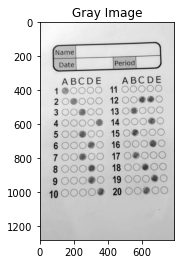

In [81]:
imgGray = GrayScaleImage(img)

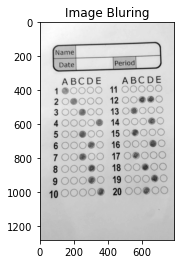

In [82]:
imgBlur = BluringImage(imgGray)

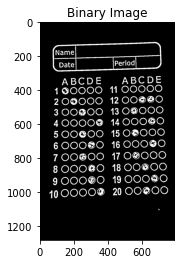

In [83]:
BinaryImage=GraytoBinary(imgBlur)

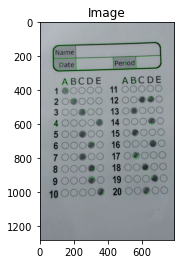

In [84]:
charsAndShapes=allContours(img,BinaryImage)

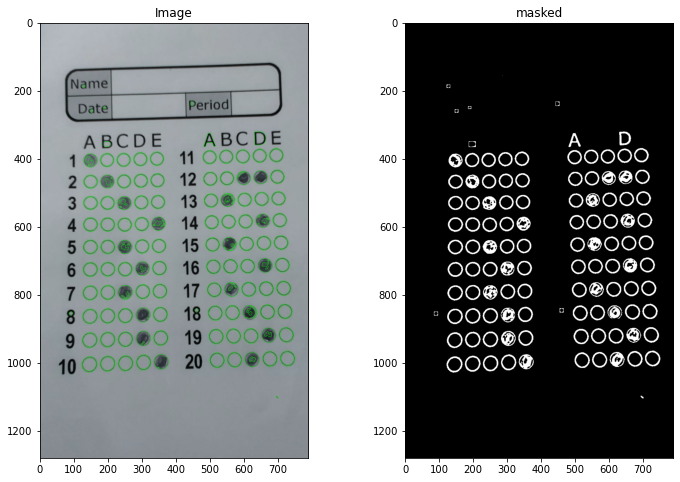

In [85]:
circles,maskimage=charandCircles(img,BinaryImage,charsAndShapes)

183
102
183


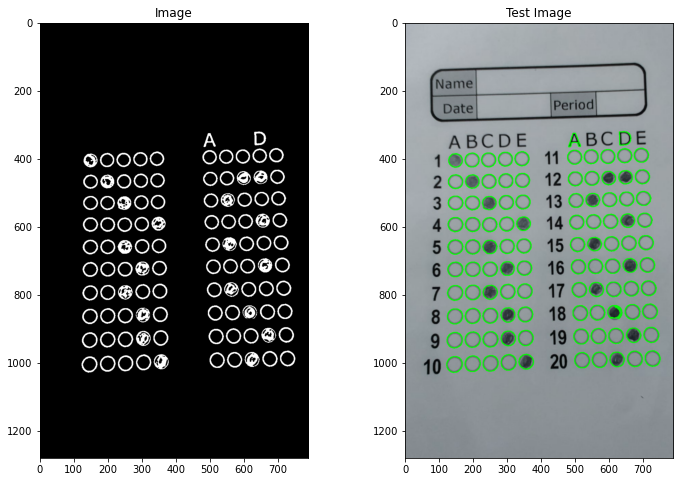

In [86]:
mask,reminder=Circle(img,BinaryImage,circles)

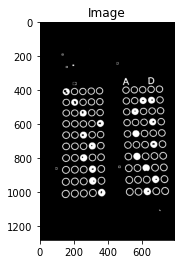

217


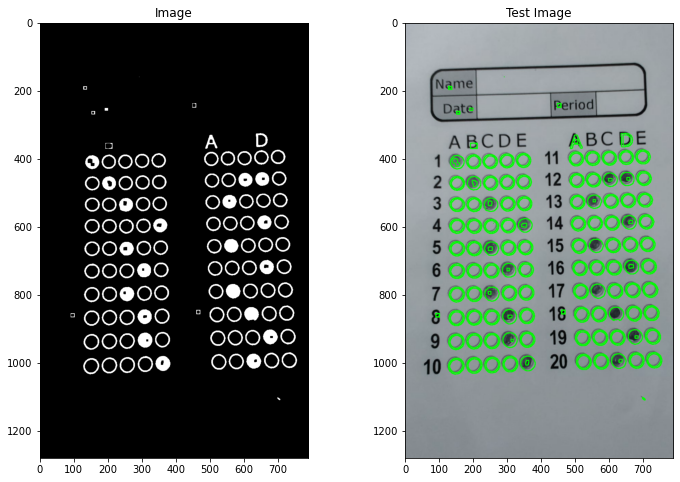

In [87]:
cnts=ClosingCircles(maskimage,img)

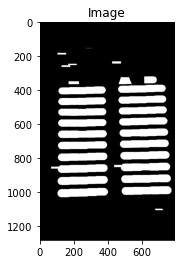

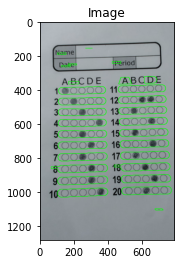

[16280. 14892. 15582. 14550. 16881. 16400. 14500. 14450. 13536. 14014.
 13156. 13965. 12735. 13916. 12690. 13536. 12880. 13720. 13019. 13392.]
[ 441. 1037. 3116. 3075.  510.  400.  676.  510.   41.]
20
9


In [88]:
rows(maskimage,img)

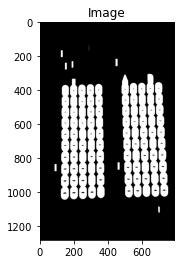

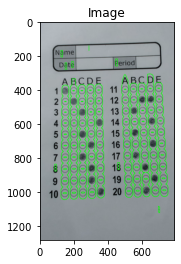

[33075. 33650. 35616. 37576. 46900. 45696. 51821. 32568. 47586. 53502.]
[351. 504. 516. 207. 198. 160. 152. 108.  96.  75.  65.  44. 198. 168.
 152. 102.  65.  65.  52. 198. 126.  75.  75.  72.  55.  65. 168. 140.
 119.  96.  78.  70.  72.  65. 168.  16.  18. 126. 119.  90.  70.  65.
  65. 189. 160. 133. 102.  70.  60.  70. 189. 140. 160. 126. 102.  80.
  70.  70.  65.  52. 198. 189. 160. 144. 126.  90.  60.  65.  65. 189.
 160. 133. 108. 102.  84.  65.  70.  70.  55. 189. 152. 133.  90.  70.
  65. 440. 380. 516. 440.  31.]
10
90


In [89]:
columns(maskimage,img)